# Data Description

I am using the data containing the results of every soccer match played in the England Premier League from 1993 to 2018:

In [1]:
import pandas as pd

results = pd.read_csv("data/EPL_Set.csv")
results.head()

Div      Date     HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  HTR  \
0  E0  14/08/93      arsenal        coventry     0     3   A   NaN   NaN  NaN   
1  E0  14/08/93  aston villa             qpr     4     1   H   NaN   NaN  NaN   
2  E0  14/08/93      chelsea       blackburn     1     2   A   NaN   NaN  NaN   
3  E0  14/08/93    liverpool  sheffield weds     2     0   H   NaN   NaN  NaN   
4  E0  14/08/93     man city           leeds     1     1   D   NaN   NaN  NaN   

    Season  
0  1993-94  
1  1993-94  
2  1993-94  
3  1993-94  
4  1993-94

The data contains the teams played, the season the game was played and the result of the game.

---

## Training Natural Language Understanding Component

To train a Rasa NLU model we will need some real conversational data. grouping user messages by their intents. The intent describes what the messages mean. Another important part of training data are entities - pieces of information which help a chatbot understand what specifically a user is asking about

In [2]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [2]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

#import en_core_web_sm  # or any other model you downloaded via spacy download or pip

import sys
!{sys.executable} -m spacy download en
#!{sys.executable} -m spacy link en_core_web_sm en

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))


    Linking successful
    E:\Applications\Anaconda3\envs\mie451-assignment-ci\lib\site-packages\en_core_web_sm
    -->
    E:\Applications\Anaconda3\envs\mie451-assignment-ci\lib\site-packages\spacy\data\en

    You can now load the model via spacy.load('en')



## Natural Language Understanding

Before anything, our chatbot needs to understand the user before doing any processing. This is done by a Rasa NLU model which will parse user inputs and perform intent classification and entity extraction tasks. To do this, we have to provide some sample conversational data.

First, we group possible user inputs by their intent (e.g. "hello", "hi", "hey" are different inputs with the same "greet" intent):

In [4]:
!type samples\sample_intents.md

## intent:greet
- hey
- hello there
- hi
- hello there
- good morning
- good evening
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- see you
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later
- good bye

## intent:affirm
- yes
- indeed
- of course
- that sounds good
- correct
- definitely
- absolutely
- sure
- yep

## intent:deny
- no
- never
- I don't think so
- don't like that
- no way
- not really
- nope
- definitely no
- no no

## intent:thanks
- thanks
- thank you
- thank you very much
- thanks a lot
- thank you so much
- thank you loads
- tnx


We also need to define the preprocessing pipeline that the user input has to go through for the intent/entity extractors to work. 

### Training the NLU Model

In [3]:
from rasa_nlu.training_data import load_data
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu_data/intents.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data, verbose=True)

# store it for future use
model_directory = trainer.persist("models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu_data/intents.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 69 (8 distinct intents)
	- Found intents: 'inform', 'presence_check', 'affirm', 'deny', 'greet', 'thanks', 'goodbye', 'results_query'
	- entity examples: 19 (2 distinct entities)
	- found entities: 'team', 'season'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_entity_featurizer_regex
INFO:rasa_nlu.model:Finished training

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into 'D:\UT\MIE1513\assignment-cai-austinchencym\lab\models\nlu\default\current'


### Using and Evaluating the NLU Model

We can evaluate the trained model to see how the model captures the intents and entities in test data:

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu_data/intents.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 69 (8 distinct intents)
	- Found intents: 'inform', 'deny', 'affirm', 'goodbye', 'results_query', 'greet', 'thanks', 'presence_check'
	- entity examples: 19 (2 distinct entities)
	- found entities: 'season', 'team'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 69 examples that have a defined intent out of 69 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9854820415879019
INFO:rasa_nlu.evaluate:Precision: 0.9866220735785953
INFO:rasa_nlu.evaluate:Accuracy:  0.9855072463768116
INFO:rasa_nlu.evaluate:Classification report: 
                precision    recall  f1-score   support

        affirm       1.00      1.00      1.00         9
          deny       1.00      1.00    

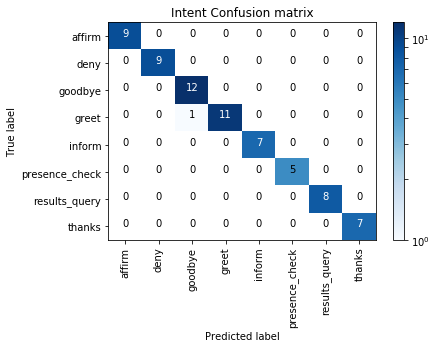

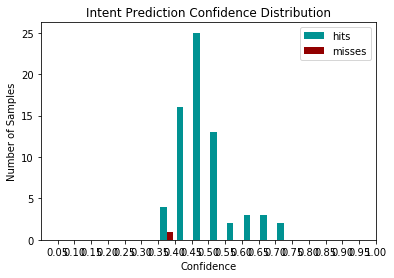

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

  no_entity       1.00      1.00      1.00       163
     season       1.00      1.00      1.00        18
       team       1.00      1.00      1.00        21

avg / total       1.00      1.00      1.00       202



In [6]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu_data/intents.md", model_directory)

We are going to get good performance if we evaluate the model on training data. We can also have additional intents data set aside only for evaluation:

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu_data/intents_eval.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 7 (2 distinct intents)
	- Found intents: 'results_query', 'greet'
	- entity examples: 6 (1 distinct entities)
	- found entities: 'team'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 7 examples that have a defined intent out of 7 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.7792207792207791
INFO:rasa_nlu.evaluate:Precision: 0.8571428571428571
INFO:rasa_nlu.evaluate:Accuracy:  0.7142857142857143
INFO:rasa_nlu.evaluate:Classification report: 
               precision    recall  f1-score   support

       affirm       0.00      0.00      0.00         0
        greet       0.00      0.00      0.00         1
       inform       0.00      0.00      0.00         0
results

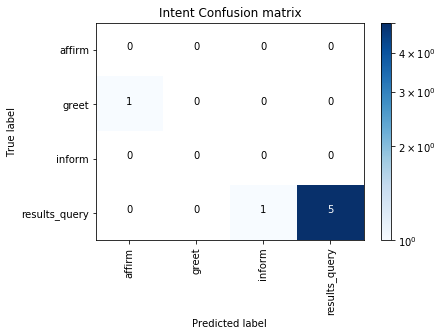

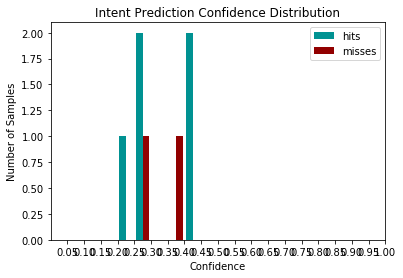

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9280000000000002
INFO:rasa_nlu.evaluate:Precision: 0.9384615384615385
INFO:rasa_nlu.evaluate:Accuracy:  0.9333333333333333
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

  no_entity       0.92      1.00      0.96        24
       team       1.00      0.67      0.80         6

avg / total       0.94      0.93      0.93        30



In [7]:
run_evaluation("nlu_data/intents_eval.md", model_directory)

We can also test the model's performance continously with user input:

In [8]:
while True:
    q = input()
    parsed_query = interpreter.parse(q)
    parsed_intent = parsed_query.get('intent')
    parsed_entities = parsed_query.get('entities')
    
    print("Intent:"), pprint(parsed_intent)
    print("Entities:"), pprint(parsed_entities)
    if q == 'stop':
        break

hi
Intent:
{
  "name": "greet",
  "confidence": 0.4970099844102098
}
Entities:
[]
goodbuy
Intent:
{
  "name": "greet",
  "confidence": 0.3690685983624104
}
Entities:
[]
goodbye
Intent:
{
  "name": "goodbye",
  "confidence": 0.46323549924161345
}
Entities:
[]
i want info on man city
Intent:
{
  "name": "presence_check",
  "confidence": 0.3825821507547538
}
Entities:
[
  {
    "start": 15,
    "end": 23,
    "value": "man city",
    "entity": "team",
    "confidence": 0.8534566872757261,
    "extractor": "ner_crf"
  }
]
how did man city do in 1996-97
Intent:
{
  "name": "results_query",
  "confidence": 0.47049099572370123
}
Entities:
[
  {
    "start": 8,
    "end": 16,
    "value": "man city",
    "entity": "team",
    "confidence": 0.8166226279038855,
    "extractor": "ner_crf"
  },
  {
    "start": 23,
    "end": 30,
    "value": "1996 - 97",
    "entity": "season",
    "confidence": 0.9398971072751022,
    "extractor": "ner_crf"
  }
]
stop
Intent:
{
  "name": "greet",
  "confidence":

## Handling the Dialogue


We have taught our assistant how to understand user inputs. Now, it's time to teach it how to make responses by training a dialogue management model using Rasa Core.

### Defining the Bot's Actions

The bot's responses either follow a simple text response (utter action) or can be implemented as custom actions which are coded in Python classes:

In [9]:
!type samples\sample_action.py

from rasa_core_sdk import Action

class SampleAction(Action):
    def name(self):
        return "action_sample_action"

    def run(self, dispatcher, tracker, domain):
        slot = tracker.get_slot('slot')
        
        dispatcher.utter_message("slot value = {}".format(slot))


### Defining the Domain

The domain specifies the universe that the bot operates in. In our case this universe consists of intents and entities as well as the actions which appear in training stories. The domain can also contain the templates for the answers a bot should use to respond to the user and slots which will help the bot to keep track of the context. 

In [10]:
!type samples\sample_domain.yml

intents:
  - greet 
  - goodbye
  - affirm
  - deny
  - thanks

slots:
  sample_slot:
    type: text

entities:
  - sample_entity

actions:
  - utter_greet
  - utter_goodbye
  
templates:
  utter_greet:
    - text: "Hello!"
    - text: "Hey!!"
  utter_goodbye:
    - text: "Bye!"
  


## Stories

Dialogues are represented with stories in Rasa. A story is an actual conversation where user inputs are expressed as intents as well as corresponding entities, and chatbot responses are expressed as actions:

In [11]:
!type samples\sample_stories.md

## Sample Story
* greet
    - utter_greet
* results_query
    - utter_what_team
* inform{"team":"Arsenal"}
    - utter_what_season
* inform{"season":"1996-97"}
    - action_get_results
* thanks
    - utter_np
* goodbye
    - utter_goodbye


Here is a visualization of the interaction sequence of the stories:

![](story_graph.png)

## Training the Dialogue Model

With everything in the domain defined, we can now train the dialogue model which handles the users queries:

In [4]:
from rasa_core.policies import KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy()])

# loading our training dialogues
training_data = agent.load_data('nlu_data/stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=200
)

agent.persist('models/dialogue')

INFO:apscheduler.scheduler:Scheduler started
E:\Applications\Anaconda3\envs\mie451-assignment-ci\lib\site-packages\pykwalify\core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
Processed Story Blocks: 100%|████████████████████████| 7/7 [00:00<00:00, 138.12it/s, # trackers=12]
Processed actions: 309it [00:00, 433.90it/s, # examples=309]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 24)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                7296      
_________________________________________________________________
dense (Dense)                (None, 12)                396       
_________________________________________________________________
activation (Activation)      (None, 12)                0         
Total params: 7,692
Trainable params: 7,692
Non-trainable params: 0
_________________________________________________________________


INFO:rasa_core.policies.keras_policy:Fitting model with 309 total samples and a validation split of 0.0


Epoch 1/200
309/309 [==============================] - ETA: 7s - loss: 2.5415 - acc: 0.031 - 1s 3ms/step - loss: 2.4268 - acc: 0.1683
Epoch 2/200
309/309 [==============================] - ETA: 0s - loss: 2.3175 - acc: 0.343 - 0s 178us/step - loss: 2.2494 - acc: 0.4239
Epoch 3/200
309/309 [==============================] - ETA: 0s - loss: 2.1013 - acc: 0.531 - 0s 162us/step - loss: 2.0824 - acc: 0.5016
Epoch 4/200
309/309 [==============================] - ETA: 0s - loss: 1.8592 - acc: 0.656 - 0s 172us/step - loss: 1.9157 - acc: 0.5016
Epoch 5/200
309/309 [==============================] - ETA: 0s - loss: 1.9071 - acc: 0.406 - 0s 154us/step - loss: 1.8053 - acc: 0.5016
Epoch 6/200
309/309 [==============================] - ETA: 0s - loss: 1.9963 - acc: 0.375 - 0s 155us/step - loss: 1.7276 - acc: 0.5016
Epoch 7/200
309/309 [==============================] - ETA: 0s - loss: 1.5854 - acc: 0.562 - 0s 167us/step - loss: 1.6899 - acc: 0.5016
Epoch 8/200
309/309 [=============================

Epoch 61/200
309/309 [==============================] - ETA: 0s - loss: 0.2790 - acc: 0.937 - 0s 146us/step - loss: 0.2608 - acc: 0.9644
Epoch 62/200
309/309 [==============================] - ETA: 0s - loss: 0.1898 - acc: 1.000 - 0s 162us/step - loss: 0.2333 - acc: 0.9741
Epoch 63/200
309/309 [==============================] - ETA: 0s - loss: 0.2895 - acc: 0.937 - 0s 152us/step - loss: 0.2564 - acc: 0.9579
Epoch 64/200
309/309 [==============================] - ETA: 0s - loss: 0.2286 - acc: 0.968 - 0s 172us/step - loss: 0.2344 - acc: 0.9644
Epoch 65/200
309/309 [==============================] - ETA: 0s - loss: 0.1979 - acc: 0.968 - 0s 175us/step - loss: 0.2433 - acc: 0.9547
Epoch 66/200
309/309 [==============================] - ETA: 0s - loss: 0.3345 - acc: 0.968 - 0s 152us/step - loss: 0.2334 - acc: 0.9709
Epoch 67/200
309/309 [==============================] - ETA: 0s - loss: 0.1898 - acc: 1.000 - 0s 137us/step - loss: 0.2196 - acc: 0.9644
Epoch 68/200
309/309 [===================

309/309 [==============================] - ETA: 0s - loss: 0.0554 - acc: 0.968 - 0s 156us/step - loss: 0.0639 - acc: 0.9838
Epoch 180/200
309/309 [==============================] - ETA: 0s - loss: 0.0419 - acc: 1.000 - 0s 158us/step - loss: 0.0377 - acc: 0.9968
Epoch 181/200
309/309 [==============================] - ETA: 0s - loss: 0.0532 - acc: 1.000 - 0s 178us/step - loss: 0.0478 - acc: 0.9871
Epoch 182/200
309/309 [==============================] - ETA: 0s - loss: 0.0154 - acc: 1.000 - 0s 170us/step - loss: 0.0395 - acc: 0.9903
Epoch 183/200
309/309 [==============================] - ETA: 0s - loss: 0.0599 - acc: 0.968 - 0s 156us/step - loss: 0.0419 - acc: 0.9903
Epoch 184/200
309/309 [==============================] - ETA: 0s - loss: 0.0069 - acc: 1.000 - 0s 170us/step - loss: 0.0271 - acc: 0.9968
Epoch 185/200
309/309 [==============================] - ETA: 0s - loss: 0.0778 - acc: 1.000 - 0s 159us/step - loss: 0.0296 - acc: 1.0000
Epoch 186/200
309/309 [=========================

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to 'D:\UT\MIE1513\assignment-cai-austinchencym\lab\models\dialogue'


## Testing the Bot

We now have everything needed to run the bot. The only remaining thing to take care of is setting up a server listening for requests for custom actions. You can use the following commands and configurations in the assignment to set up the server easily.

First we have to define a webhook configuration file:

In [5]:
!type endpoint.yml

action_endpoint:
  url: "http://localhost:5055/webhook"


The actions server can now be started with the following command from the command line:

**python -m rasa_core_sdk.endpoint --actions actions**

After setting up the server, we can start the bot and talk with it!

In [ ]:
!{sys.executable} -m rasa_core_sdk.endpoint --actions actions

In [ ]:
import IPython
from IPython.display import clear_output
from rasa_core.agent import Agent
from rasa_core.interpreter import NaturalLanguageInterpreter
from rasa_core.utils import EndpointConfig

messages = ["Hi! you can chat in this window. Type 'stop' to end the conversation."]
interpreter = NaturalLanguageInterpreter.create('models/nlu/default/current/')
endpoint = EndpointConfig('http://localhost:5055/webhook')
agent = Agent.load('models/dialogue', interpreter=interpreter, action_endpoint = endpoint)
tracker = agent.tracker_store.get_or_create_tracker("sender_id") 
# get current tracker state
tracker.current_state()

print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    pprint(interpreter.parse(a))
    responses = agent.handle_text(a)
    for response in responses:
        print(response["text"])

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
E:\Applications\Anaconda3\envs\mie451-assignment-ci\lib\site-packages\pykwalify\core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)


Your bot is ready to talk! Type your messages here or send 'stop'
hi
{
  "intent": {
    "name": "greet",
    "confidence": 0.5678913308114328
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "greet",
      "confidence": 0.5678913308114328
    },
    {
      "name": "affirm",
      "confidence": 0.15798845776000214
    },
    {
      "name": "goodbye",
      "confidence": 0.10061730121253294
    },
    {
      "name": "deny",
      "confidence": 0.08365168634864807
    },
    {
      "name": "thanks",
      "confidence": 0.04691985895206572
    },
    {
      "name": "inform",
      "confidence": 0.025516101937521036
    },
    {
      "name": "results_query",
      "confidence": 0.009306045945722038
    },
    {
      "name": "presence_check",
      "confidence": 0.008109217032075183
    }
  ],
  "text": "hi"
}
Hello!
i want info
{
  "intent": {
    "name": "presence_check",
    "confidence": 0.21538203837599673
  },
  "entities": [],
  "intent_ranking": [
    {
      

## [OPTIONAL] Generating New Story Graphs

You can use the following code to generate new interaction diagrams for your stories. However, due to compatibility issues in the current Rasa version, the process for installing the required library (pygraphviz) is complicated and this part is only in case you are interested.

In [26]:
#! pip install pygraphviz

In [16]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("nlu_data/stories.md", "story_graph.png", max_history=2)

E:\Applications\Anaconda3\envs\mie451-assignment-ci\lib\site-packages\pykwalify\core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
Processed Story Blocks: 100%|█████████████████████████| 7/7 [00:00<00:00, 537.05it/s, # trackers=1]


ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')